## Librairies

In [115]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo 

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

In [116]:
url = "household_power_consumption.txt"

data = pd.read_csv(url, sep=';', parse_dates={'Datetime': ['Date', 'Time']}, 
                   infer_datetime_format=True, na_values=['?'], low_memory=False)

metadata = {
    'name': 'Individual household electric power consumption',
    'source': 'UCI Machine Learning Repository',
    'description': 'Measurements of electric power consumption in one household.',
}

In [117]:
display(data)

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,2010-11-26 21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


We need to remember the correlation between the active power and the global intensity with the formula : 
$$  U = R * I $$
That means we need to work on our dataset in order to predict another variable or make some adjustements to prevent overfitting on this value.

This archive contains 2 075 259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
\
One day -> 1440 observations

## Data Treatment

In [118]:
data.isna().sum()

Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

We can look at how much day those missing values actually represent : 
$$ \frac{25 979}{1 440} \approx 18 $$
It actually represent 18 days so approximatly 1% of the dataset is missing, we can choose to just delete those lines but we will look to fill them in order to have the best model. We can also compare performance for missing values treatment and no treatment.

In [119]:
missing_day = data[
    (data['Datetime'].dt.strftime('%Y-%m-%d') == '2007-04-28') | 
    (data['Datetime'].dt.strftime('%Y-%m-%d') == '2007-04-29') | 
    (data['Datetime'].dt.strftime('%Y-%m-%d') == '2007-04-30')
]
#display(missing_day)

start_time = pd.Timestamp('2007-04-28 00:21:00')
end_time = pd.Timestamp('2007-04-28 23:59:00')
filtered_data = missing_day[
    (missing_day['Datetime'] >= start_time) & 
    (missing_day['Datetime'] <= end_time)
]

display(filtered_data)


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
190497,2007-04-28 00:21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190498,2007-04-28 00:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190499,2007-04-28 00:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190500,2007-04-28 00:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190501,2007-04-28 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
191911,2007-04-28 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191912,2007-04-28 23:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191913,2007-04-28 23:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191914,2007-04-28 23:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need to treat those missing values, we can use : 
- Mean
- Median

We can maybe find some relations between variables to help us treat those missing values with better care.

In [120]:
data = data.fillna(data.mean(numeric_only=True))

In [121]:
missing_day = data[
    (data['Datetime'].dt.strftime('%Y-%m-%d') == '2007-04-28') | 
    (data['Datetime'].dt.strftime('%Y-%m-%d') == '2007-04-29') | 
    (data['Datetime'].dt.strftime('%Y-%m-%d') == '2007-04-30')
]
#display(missing_day)

start_time = pd.Timestamp('2007-04-28 00:21:00')
end_time = pd.Timestamp('2007-04-28 23:59:00')
filtered_data = missing_day[
    (missing_day['Datetime'] >= start_time) & 
    (missing_day['Datetime'] <= end_time)
]

display(filtered_data)

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
190497,2007-04-28 00:21:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447
190498,2007-04-28 00:22:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447
190499,2007-04-28 00:23:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447
190500,2007-04-28 00:24:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447
190501,2007-04-28 00:25:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447
...,...,...,...,...,...,...,...,...
191911,2007-04-28 23:55:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447
191912,2007-04-28 23:56:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447
191913,2007-04-28 23:57:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447
191914,2007-04-28 23:58:00,1.091615,0.123714,240.839858,4.627759,1.121923,1.29852,6.458447


In [122]:
data.isna().sum()

Datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

We will use the cyclic encoding to help building relations with hours.

In [123]:
# Take the information we need 
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y-%m-%d %H:%M:%S')
data['DayofWeek'] = data['Datetime'].dt.dayofweek
data['Year'] = data['Datetime'].dt.year
data['Month'] = data['Datetime'].dt.month
data['Day'] = data['Datetime'].dt.day
data['Hour'] = data['Datetime'].dt.hour
data['Minute'] = data['Datetime'].dt.minute

# Dropping date
data = data.drop('Datetime', axis=1)

# Cyclical transformation hour
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data = data.drop('Hour', axis=1)

# Cyclical transformation day for year
data['DayYEAR_cos'] = np.cos(2 * np.pi * data['Day'] / 365)
data['DayYEAR_sin'] = np.sin(2 * np.pi * data['Day'] / 365)

# Cyclical transformation day for week
data['DayWeek_cos'] = np.cos(2 * np.pi * data['DayofWeek'] / 7)
data['DayWeek_sin'] = np.sin(2 * np.pi * data['DayofWeek'] / 7)

# Cyclical transformation month
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)

data = data.drop(['Month','Day','DayofWeek'], axis=1)

With the formula given : 
$$ \left( \frac{\text{global\_active\_power} \times 1000}{60} - \text{sub\_metering\_1} - \text{sub\_metering\_2} - \text{sub\_metering\_3} \right) = \text{active\_energy}$$
representing the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

In [124]:
display(data)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Minute,Hour_cos,Hour_sin,DayYEAR_cos,DayYEAR_sin,DayWeek_cos,DayWeek_sin,Month_cos,Month_sin
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,24,-0.258819,-0.965926,0.962309,0.271958,-0.222521,-0.974928,1.000000,-2.449294e-16
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,25,-0.258819,-0.965926,0.962309,0.271958,-0.222521,-0.974928,1.000000,-2.449294e-16
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006,26,-0.258819,-0.965926,0.962309,0.271958,-0.222521,-0.974928,1.000000,-2.449294e-16
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006,27,-0.258819,-0.965926,0.962309,0.271958,-0.222521,-0.974928,1.000000,-2.449294e-16
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006,28,-0.258819,-0.965926,0.962309,0.271958,-0.222521,-0.974928,1.000000,-2.449294e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.43,4.0,0.0,0.0,0.0,2010,58,0.500000,-0.866025,0.901502,0.432776,-0.900969,-0.433884,0.866025,-5.000000e-01
2075255,0.944,0.000,240.00,4.0,0.0,0.0,0.0,2010,59,0.500000,-0.866025,0.901502,0.432776,-0.900969,-0.433884,0.866025,-5.000000e-01
2075256,0.938,0.000,239.82,3.8,0.0,0.0,0.0,2010,0,0.707107,-0.707107,0.901502,0.432776,-0.900969,-0.433884,0.866025,-5.000000e-01
2075257,0.934,0.000,239.70,3.8,0.0,0.0,0.0,2010,1,0.707107,-0.707107,0.901502,0.432776,-0.900969,-0.433884,0.866025,-5.000000e-01


In [125]:
data = data.drop('Global_intensity', axis=1)

In [126]:
data['active_energy'] = (data['Global_active_power'] * 1000 / 60) - data['Sub_metering_1'] - data['Sub_metering_2'] - data['Sub_metering_3']
data = data.drop(['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3' ], axis=1)

After treating those missing values, we can now use a scaler in order to scale our data to work with them.

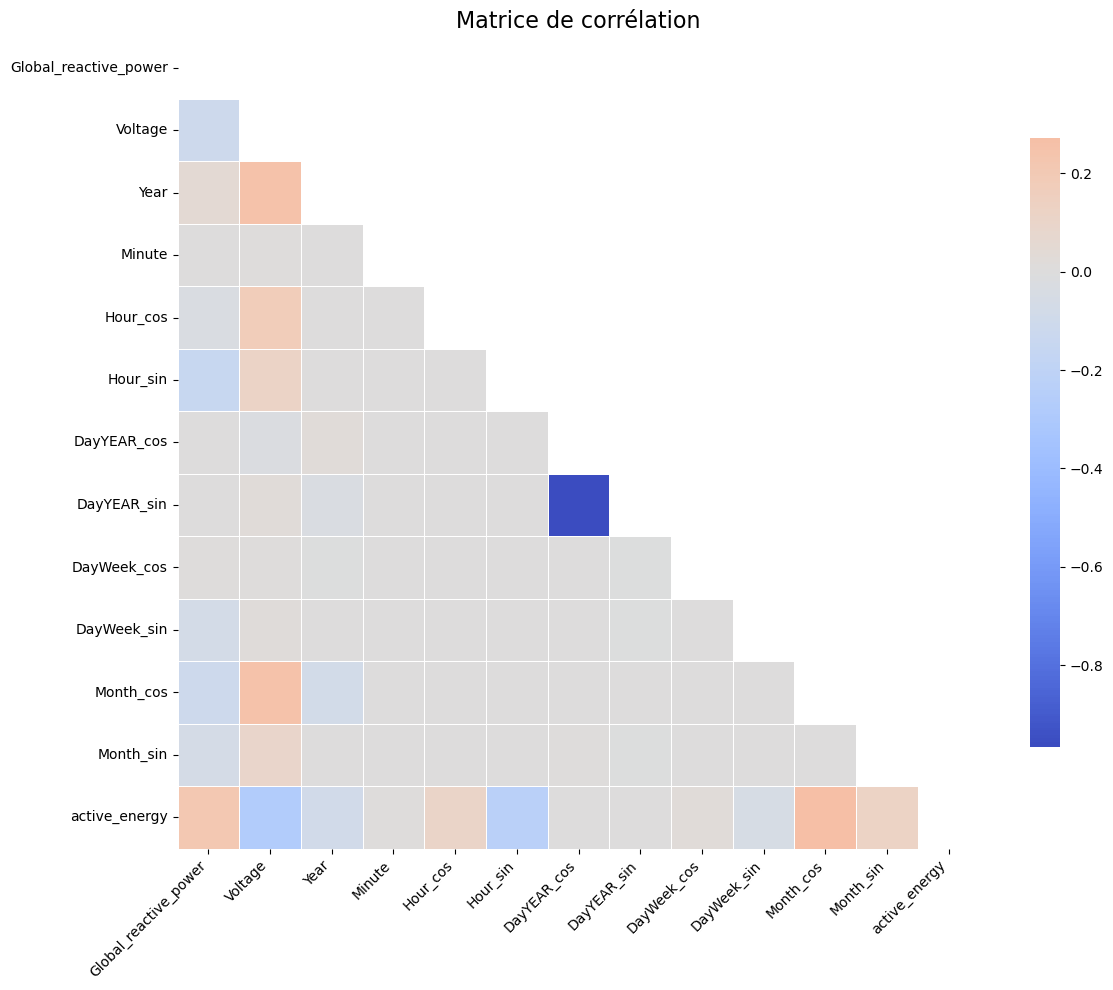

In [127]:
correlation_matrix = data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', 
            center=0, linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Matrice de corrélation', size=16)
plt.tight_layout()  
plt.show()

In [128]:
data_bis = data

## LSTM

    LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture specifically designed to model sequential data and capture long-term dependencies. Unlike standard RNNs, LSTMs use memory cells and gates (input, forget, and output gates) to control the flow of information, allowing the network to retain relevant information over long periods and mitigate the problem of vanishing gradients. This makes LSTMs highly effective for tasks involving time-series data, speech recognition, or natural language processing, where past information can be crucial for predicting future outcomes.

In [129]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import netron
import pandas as pd

# Ensure data is in NumPy array format
if isinstance(data, pd.DataFrame):
    data = data.values

# Extract features and target
# Excluding 'Global_active_power' (index 2) from features
X = np.delete(data, 2, axis=1)  # Supprime la colonne d'index 2
y = data[:, 2]  # 'Global_active_power' as the target

# Split data into train and test sets (shuffle=False to maintain time-series order)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features
train_X_scaled = scaler_X.fit_transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

# Scale target
train_y_scaled = scaler_y.fit_transform(train_y.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.reshape(-1, 1))

# Reshape input data for LSTM (samples, timesteps, features)
train_X_scaled = np.reshape(train_X_scaled, (train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))
test_X_scaled = np.reshape(test_X_scaled, (test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(4, return_sequences=True, input_shape=(train_X_scaled.shape[1], train_X_scaled.shape[2])))
model.add(Dense(1))

# Save and visualize model with Netron
model.save('model.h5')
netron.start('./models/model.h5')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with validation split
history = model.fit(
    train_X_scaled, train_y_scaled, 
    epochs=10, batch_size=32, 
    validation_split=0.2  # 20% of training data for validation
)

# Evaluate the model (using the scaled test data)
loss = model.evaluate(test_X_scaled, test_y_scaled)
print(f"LSTM Model Loss: {loss}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Serving 'model.h5' at http://localhost:21889
Epoch 1/10
41506/41506 [==============================] - 26s 586us/step - loss: 0.0304 - val_loss: 0.1479
Epoch 2/10
41506/41506 [==============================] - 23s 564us/step - loss: 0.0292 - val_loss: 0.1457
Epoch 3/10
41506/41506 [==============================] - 23s 547us/step - loss: 0.0285 - val_loss: 0.1473
Epoch 4/10
41506/41506 [==============================] - 23s 552us/step - loss: 0.0280 - val_loss: 0.1450
Epoch 5/10
41506/41506 [==============================] - 23s 552us/step - loss: 0.0277 - val_loss: 0.1461
Epoch 6/10
41506/41506 [==============================] - 24s 573us/step - loss: 0.0275 - val_loss: 0.1534
Epoch 7/10
41506/41506 [==============================] - 23s 560us/step - loss: 0.0273 - val_loss: 0.1420
Epoch 8/10
41506/41506 [==============================] - 24s 575us/step - loss: 0.0271 - val_loss: 0.1490
Epoch 9/10
41506/41506 [==============================] - 25s 604us/step - loss: 0.0270 - val_loss:

## CNN 1D

Serving 'model2.h5' at http://localhost:22914
Epoch 1/10
41506/41506 [==============================] - 24s 565us/step - loss: 0.0259 - val_loss: 0.1429
Epoch 2/10
41506/41506 [==============================] - 23s 545us/step - loss: 0.0195 - val_loss: 0.1130
Epoch 3/10
41506/41506 [==============================] - 23s 557us/step - loss: 0.0147 - val_loss: 0.1146
Epoch 4/10
41506/41506 [==============================] - 22s 532us/step - loss: 0.0121 - val_loss: 0.1185
Epoch 5/10
41506/41506 [==============================] - 22s 532us/step - loss: 0.0103 - val_loss: 0.1171
Epoch 6/10
41506/41506 [==============================] - 22s 536us/step - loss: 0.0089 - val_loss: 0.1283
Epoch 7/10
41506/41506 [==============================] - 22s 536us/step - loss: 0.0078 - val_loss: 0.1394
Epoch 8/10
41506/41506 [==============================] - 22s 533us/step - loss: 0.0068 - val_loss: 0.1433
Epoch 9/10
41506/41506 [==============================] - 23s 559us/step - loss: 0.0062 - val_loss

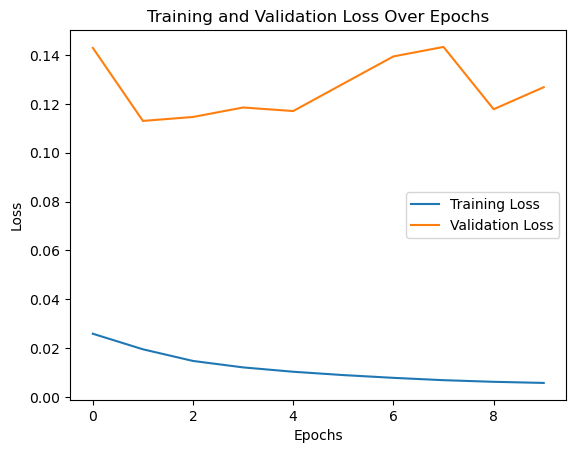

In [130]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Assuming data is a numpy array, extract features and target
X = np.delete(data, 2, axis=1)  # Supprime la colonne d'index 2
y = data[:, 2]  # 'Global_active_power' comme cible

# Split data into train and test sets (shuffle=False to maintain time-series order)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_X_scaled = scaler_X.fit_transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

train_y_scaled = scaler_y.fit_transform(train_y.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.reshape(-1, 1))

# Reshape data for 1D CNN
train_X_cnn = np.reshape(train_X_scaled, (train_X_scaled.shape[0], train_X_scaled.shape[1], 1))
test_X_cnn = np.reshape(test_X_scaled, (test_X_scaled.shape[0], test_X_scaled.shape[1], 1))

# Build the 1D CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(train_X_cnn.shape[1], 1)))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.save('model2.h5')
netron.start('./models/model2.h5')

# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Train the CNN model with validation split
history = model_cnn.fit(train_X_cnn, train_y_scaled, epochs=10, batch_size=32, 
                        validation_split=0.2)  # 20% of the training data used for validation

# Reshape the test set for evaluation
test_X_cnn = np.reshape(test_X_scaled, (test_X_scaled.shape[0], test_X_scaled.shape[1], 1))

# Evaluate CNN model
loss_cnn = model_cnn.evaluate(test_X_cnn, test_y_scaled)
print(f"1D CNN Model Loss: {loss_cnn}")

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Cours achitecture

In [134]:
def create_dataset(data, target_column_index, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # All features
        y.append(data[i + time_step, target_column_index])  # Target column
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_bis)
scaled_df = pd.DataFrame(scaled_data, columns=data_bis.columns)

target_column = 'active_energy'

time_step = 10
target_index = scaled_df.columns.get_loc(target_column)

X, y = create_dataset(scaled_data, target_index, time_step)

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mean_squared_error')

model.save('model.h5')
netron.start('model.h5')


history = model.fit(trainX, trainY, epochs=10, batch_size=128, validation_data=(testX, testY), verbose=1 )

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

train_predictions = model.predict(trainX)
test_predictions = model.predict(testX)

Serving 'model.h5' at http://localhost:20624
Epoch 1/10
12971/12971 [==============================] - 124s 9ms/step - loss: 7.4517e-04 - val_loss: 2.8405e-04
Epoch 2/10
12971/12971 [==============================] - 114s 9ms/step - loss: 5.7975e-04 - val_loss: 3.0959e-04
Epoch 3/10
12971/12971 [==============================] - 2208s 170ms/step - loss: 5.5784e-04 - val_loss: 2.7252e-04
Epoch 4/10
12971/12971 [==============================] - 7597s 586ms/step - loss: 5.4342e-04 - val_loss: 2.7969e-04
Epoch 5/10
 6513/12971 [==============>...............] - ETA: 22:55 - loss: 5.3799e-04

KeyboardInterrupt: 